In [1]:
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from PIL import Image
from tensorflow import keras
from glob import glob
import pandas as pd
import imutils
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import argparse
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

# 2차로 받은 추가 데이터입니다

# Data Pre-processing

In [2]:
#각 엑셀 파일에서 Rp, Rs 값 추출

file_names_list = []
imp_list = []
dir = "data_files/0713/excel_files"

for file in os.listdir(dir):
    file_name = dir + "/" + file
    f = open(file_name,'r', encoding='UTF8')
    rdr = list(csv.reader(f))
    Rp = round(float(rdr[120][8])/5, 3)
    #Rs = round(float(rdr[120][10]), 3)
    file_names_list.append(file.split("_")[1].replace(" ", "").replace(",", "").replace(".", ""))
    imp_list.append(Rp)
    
    print("file : ", file, "    Rp : ", Rp)
    
    f.close()


file :  Generic C-f [(1) _30, 1, no.6_; 7_3_2023 1_46_05 PM].csv     Rp :  5231.247
file :  Generic C-f [(1) _30, 3, no.7_; 7_3_2023 1_50_42 PM].csv     Rp :  10062.235
file :  Generic C-f [(1) _30, 5, no.1_; 7_3_2023 1_52_00 PM].csv     Rp :  41851.774
file :  Generic C-f [(1) _30, 5, no.2_; 7_3_2023 1_52_26 PM].csv     Rp :  38676.64
file :  Generic C-f [(1) _30, 5, no.4_; 7_3_2023 1_53_19 PM].csv     Rp :  55231.378
file :  Generic C-f [(1) _30, 5, no.5_; 7_3_2023 1_53_47 PM].csv     Rp :  49048.821
file :  Generic C-f [(1) _30, 5, no.7_; 7_3_2023 1_54_59 PM].csv     Rp :  39845.003
file :  Generic C-f [(1) _30, 7, no.1_; 7_3_2023 1_55_40 PM].csv     Rp :  54464.896
file :  Generic C-f [(1) _40, 1, no.5_; 7_3_2023 1_26_50 PM].csv     Rp :  3377.876
file :  Generic C-f [(1) _40, 5, no.2_; 7_3_2023 1_33_31 PM].csv     Rp :  14005.014
file :  Generic C-f [(10) _40, 3, no.5_; 7_3_2023 1_30_34 PM].csv     Rp :  8857.827
file :  Generic C-f [(10) _70, 3, no.5_; 7_3_2023 12_16_08 PM].csv  

In [ ]:
# save cropped images with impedance values on their file names

In [3]:
ground_dir = "data_files/0713/"
image_dir = ground_dir + "images"
make_dir = ground_dir + "processed_images_Rp"
os.makedirs(make_dir)

count = 0

for file in os.listdir(image_dir):
    
    original_image_name = file[:-4].replace(" ", "").replace(",", "").replace(".", "")
    
    try:
        imp_index = file_names_list.index(original_image_name)
    except ValueError:
        print("cannot find excel file for : " + file)
        continue
     
    new_image_name = imp_list[imp_index]
    image = load_img(image_dir + "/" + file)
    cropped_image = image.crop((0,448,2560,1472))
    cropped_image.save(make_dir + "/" + str(new_image_name) + ".jpg")
    
    count += 1
    
print("saved " + str(count) + " images")

cannot find excel file for : 30, 3, no.1.jpg
cannot find excel file for : 30, 3, no.2.jpg
cannot find excel file for : 40, 3, no.3.jpg
cannot find excel file for : 40, 3, no.7.jpg
cannot find excel file for : 40, 5, no.3.jpg
cannot find excel file for : 40, 5, no.7.jpg
cannot find excel file for : 40, 7, no.1.jpg
cannot find excel file for : 40, 7, no.2.jpg
cannot find excel file for : 40, 7, no.4.jpg
cannot find excel file for : 40, 7, no.6.jpg
cannot find excel file for : 40, 7, no.7.jpg
cannot find excel file for : 40, 9, no.2.jpg
cannot find excel file for : 50, 5, no.1.jpg
cannot find excel file for : 50, 7, no.1.jpg
cannot find excel file for : 50, 7, no.6.jpg
cannot find excel file for : 60, 5, no.7.jpg
cannot find excel file for : 60, 7, no.7.jpg
cannot find excel file for : 60, 9, no.7.jpg
cannot find excel file for : 70, 1, no.1.jpg
cannot find excel file for : 70, 1, no.2.jpg
cannot find excel file for : 70, 1, no.3.jpg
cannot find excel file for : 70, 1, no.4.jpg
cannot fin

# CNN Training

In [4]:
# 학습용 이미지 쪼개기
# 저장된 이미지는 (1024*2560)

image_width = 256
image_height = 1024
rows = 1
columns = 10

X = []
Y = []

for file_name in os.listdir(make_dir):
    if file_name != '.DS_Store':
        image = Image.open(make_dir+"/"+file_name).convert("L")
        for j in range(rows):

            for i in range(columns):
                cropped = image.crop((i*image_width,j*image_height,(i+1)*image_width,(j+1)*image_height))
                cropped = np.array(cropped)
                X.append(cropped)
                Y.append(int(float(file_name[:-4])))

In [5]:
X = np.array(X)/255.0
Y = np.array(Y)
print(X.shape, Y.shape)

(1330, 1024, 256) (1330,)


In [6]:
standard_scaler_y = StandardScaler()
reshape_y = Y.reshape(-1,1)
reshape_y = standard_scaler_y.fit_transform(reshape_y)

In [7]:
test_size = 0.2
shuffle = True
random_state = 42

train_x, test_x, train_y, test_y = train_test_split(X, reshape_y, test_size=test_size, shuffle=shuffle, random_state=random_state)

In [8]:
# callback
patience=10
early_stopping_cb = EarlyStopping(patience=patience, restore_best_weights=True, monitor='val_loss')

In [9]:
train_x_cnn = train_x[..., np.newaxis]
test_x_cnn = test_x[..., np.newaxis]

In [10]:
train_x_cnn.shape

(1064, 1024, 256, 1)

In [11]:
train_y.shape

(1064, 1)

In [12]:

# sequential model
cnn_model = keras.models.Sequential()

# input and convolutional layer
cnn_model.add(keras.layers.Conv2D(32, 7, activation='relu', padding='same',
                                  input_shape=[1024, 256, 1]))
# pooling layer
cnn_model.add(keras.layers.MaxPooling2D(2))

# convolutional layers and pooling layer
cnn_model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.MaxPooling2D(2))

# convolutional layers and pooling layer
cnn_model.add(keras.layers.Conv2D(128, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.Conv2D(128, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.MaxPooling2D(2))

# flatten layer
cnn_model.add(keras.layers.Flatten())

# dense layers
cnn_model.add(keras.layers.Dense(64, activation='relu'))
cnn_model.add(keras.layers.Dense(32, activation='relu'))

# output layer
cnn_model.add(keras.layers.Dense(1))

# model complie
cnn_model.compile(optimizer='adam',loss='mse')

In [13]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1024, 256, 32)     1600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 512, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 128, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 512, 128, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 256, 64, 64)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 64, 128)      7

In [14]:
path_directory = make_dir + ".h5"
istrue = os.path.exists(path_directory)

if not istrue:
    history = cnn_model.fit(train_x_cnn, train_y, callbacks=[early_stopping_cb],
                            epochs=100, validation_split=0.2)
    cnn_model.save(path_directory)
    print("model is saved")
else:
    cnn_model = keras.models.load_model(path_directory)
    print("model is loaded")

Epoch 1/100
27/27 [==============================] - 15s 336ms/step - loss: 1.0786 - val_loss: 1.2141
Epoch 2/100
27/27 [==============================] - 5s 190ms/step - loss: 0.9534 - val_loss: 1.2132
Epoch 3/100
27/27 [==============================] - 5s 187ms/step - loss: 0.9463 - val_loss: 1.2205
Epoch 4/100
27/27 [==============================] - 5s 186ms/step - loss: 0.9395 - val_loss: 1.2284
Epoch 5/100
27/27 [==============================] - 5s 189ms/step - loss: 0.8044 - val_loss: 0.8724
Epoch 6/100
27/27 [==============================] - 5s 189ms/step - loss: 0.7380 - val_loss: 0.8386
Epoch 7/100
27/27 [==============================] - 5s 189ms/step - loss: 0.7304 - val_loss: 0.7605
Epoch 8/100
27/27 [==============================] - 5s 188ms/step - loss: 0.5919 - val_loss: 0.8339
Epoch 9/100
27/27 [==============================] - 5s 185ms/step - loss: 0.7251 - val_loss: 0.9375
Epoch 10/100
27/27 [==============================] - 5s 184ms/step - loss: 0.7397 - val_l

# Results

In [15]:
print(cnn_model.evaluate(train_x_cnn, train_y))


34/34 [==============================] - 2s 61ms/step - loss: 0.1721
0.172121062874794


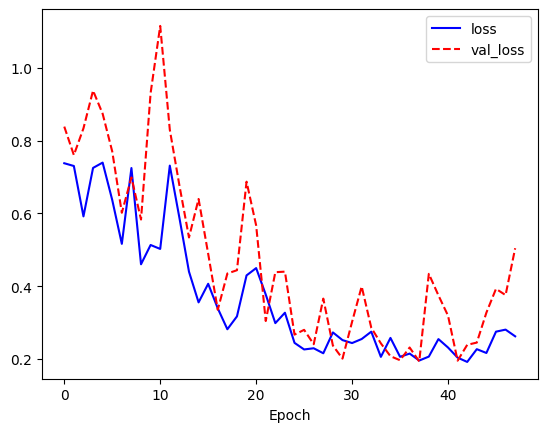

In [17]:
plt.plot(history.history['loss'][5:], 'b-', label='loss')
plt.plot(history.history['val_loss'][5:], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

9/9 [==============================] - 1s 136ms/step


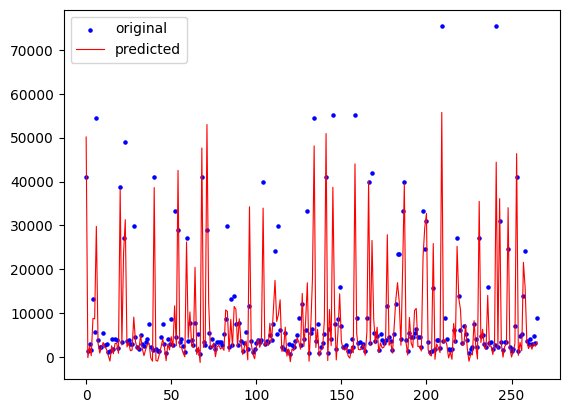

In [18]:
pred = cnn_model.predict(test_x)
inv_test_y = standard_scaler_y.inverse_transform(test_y)
inv_pred = standard_scaler_y.inverse_transform(pred)

x_ax = range(len(inv_pred))
plt.scatter(x_ax, inv_test_y, s=5, color="blue", label="original")
plt.plot(x_ax, inv_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [19]:
print("RMSE: %.4f" % mean_squared_error(inv_test_y, inv_pred)**(1/2))

RMSE: 5759.8777
